In [34]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [65]:
WINDOW_SIZE = 120
BATCH_SIZE = 30
N_EPOCHS = 100
PATH = 'data/sunspots.csv'

In [74]:
def load_data(path):
    df = pd.read_csv(path)
    df.columns = ['x', 'date', 'monthly_mean_sunspots']
    df = df.set_index('date')
    df = df['monthly_mean_sunspots']
    df.index = pd.to_datetime(df.index, format='%Y-%m-%d')
    df = df.asfreq('ME')
    return df

df = load_data(PATH)

time = df.index
series = df.values

In [78]:
#time = np.arange(0, 100, 0.1)
#series = 2*np.sin(time) + np.random.normal(0, 0.1, len(time))

test_size = 800
val_size = 200
train_val_series, train_val_time = series[:-test_size], time[:-test_size]
test_series, test_time = series[-test_size:], time[-test_size:]

train_series, train_time = train_val_series[:-val_size], train_val_time[:-val_size]
val_series, val_time = train_val_series[-val_size:], train_val_time[-val_size:]
 

train_series = train_series.reshape((len(train_series), 1))
val_series = val_series.reshape((len(val_series), 1))
test_series  = test_series.reshape((len(test_series), 1))

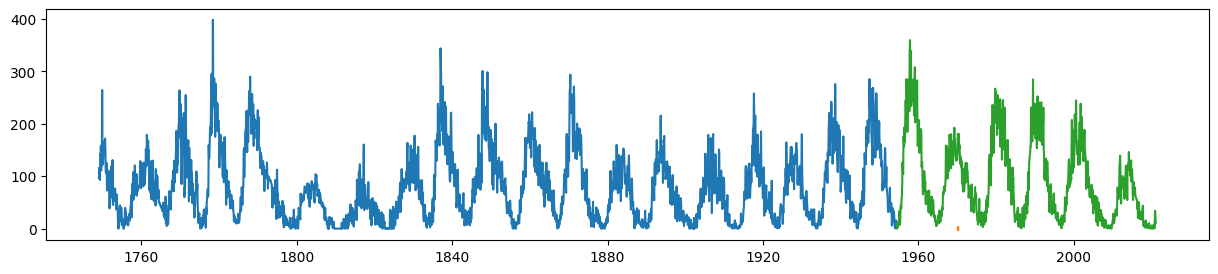

In [104]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(train_time, train_series)
ax.plot(val_time, val_series)
ax.plot(test_time, test_series)
plt.show()

480 training datapoints
80 val datapoints
200 test datapoints
35 model params


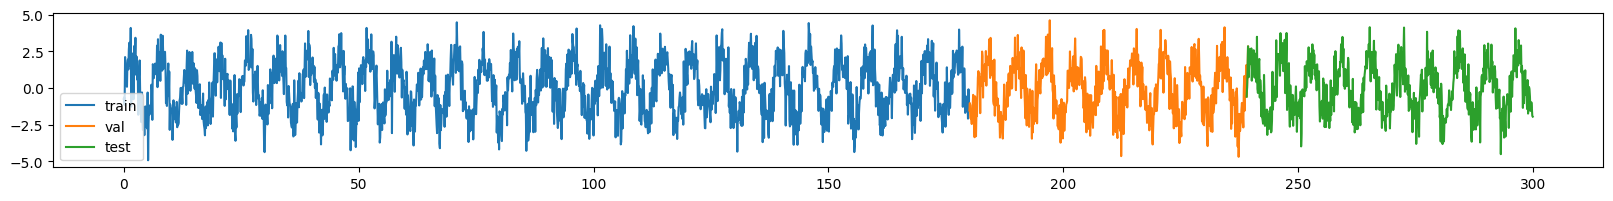

In [68]:
def split_series(time, series, train_fraction, val_fraction, test_fraction, window_size):
    train_size = int(train_fraction*len(series))
    val_size = int(val_fraction*len(series))
    test_size = int(test_fraction*len(series))

    train_series = series[:train_size]
    val_series = series[train_size:-test_size]
    test_series = series[-(test_size + window_size):]

    train_time = time[:train_size]
    val_time = time[train_size:-test_size]
    test_time = time[-(test_size + window_size):]

    return train_series, val_series, test_series, train_time, val_time, test_time


def create_windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)


def get_dataset_size(ds):
    n = 0
    for batch in ds:
        n += batch[0].shape[0]
    return n


def print_model_size_data_size(model, train_ds, val_ds, test_ds):
    print(f'{get_dataset_size(train_ds)} training datapoints')
    print(f'{get_dataset_size(val_ds)} val datapoints')
    print(f'{get_dataset_size(test_ds)} test datapoints')
    print(f'{model.count_params()} model params')


def make_model(window_size, nunits):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(window_size, 1)),
        tf.keras.layers.LSTM(nunits, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    print_model_size_data_size(model, train_ds, val_ds, test_ds)
    return model


train_series, val_series, test_series, train_time, val_time, test_time = split_series(
    time, 
    series, 
    train_fraction=0.6, 
    val_fraction=0.2, 
    test_fraction=0.2,
    window_size=WINDOW_SIZE
)

train_ds = create_windowed_dataset(train_series, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER)
val_ds = create_windowed_dataset(val_series, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER)
test_ds = create_windowed_dataset(test_series, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER)

model = make_model(WINDOW_SIZE, 2)

In [80]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


train_generator = TimeseriesGenerator(
    train_series, 
    train_series,
    length=WINDOW_SIZE, 
    sampling_rate=1,
    stride=1,
    batch_size=BATCH_SIZE
)

test_generator = TimeseriesGenerator(
    test_series, 
    test_series,
    length=WINDOW_SIZE, 
    sampling_rate=1,
    stride=1,
    batch_size=BATCH_SIZE
)

In [98]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(WINDOW_SIZE, 1)),
    tf.keras.layers.LSTM(2, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse')

In [100]:
history = model.fit(train_generator, batch_size=1, validation_split=0.1, epochs=N_EPOCHS, verbose=1)

ValueError: Argument `validation_split` is only supported for tensors or NumPy arrays.Found incompatible type in the input: [<class 'keras.src.legacy.preprocessing.sequence.TimeseriesGenerator'>]

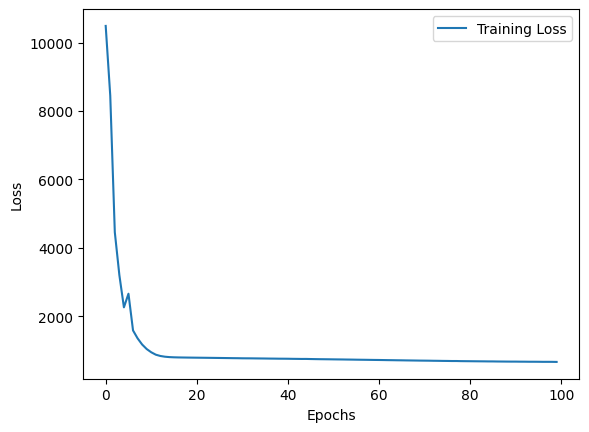

In [83]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='Training Loss')
#ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.legend()
plt.show()

In [86]:
test_predictions = model.predict(test_generator)
train_predictions = model.predict(train_generator)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


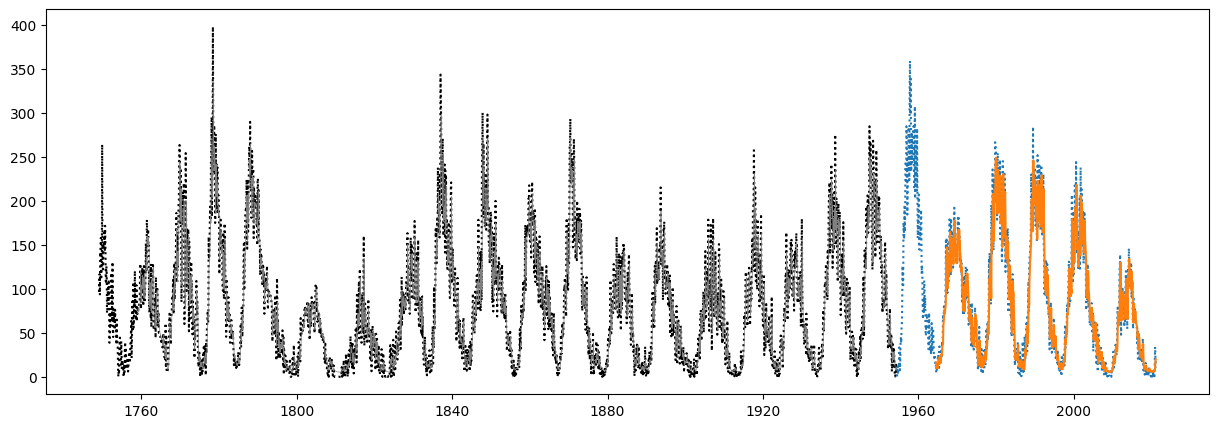

In [97]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train_time, train_series, ':', color='black', label='y_train')
ax.plot(train_time[WINDOW_SIZE:], train_predictions, color='gray', linewidth=0.5, label='y_train_pred')

ax.plot(test_time, test_series, ':')
ax.plot(test_time[WINDOW_SIZE:], test_predictions)
plt.show()

In [71]:
ypred = []
ytest = []
for batch in test_ds:
    inputs, targets = batch
    ypred_batch = model.predict(inputs, verbose=0)
    ypred.extend(ypred_batch.flatten())
    ytest.extend(targets.numpy().flatten())

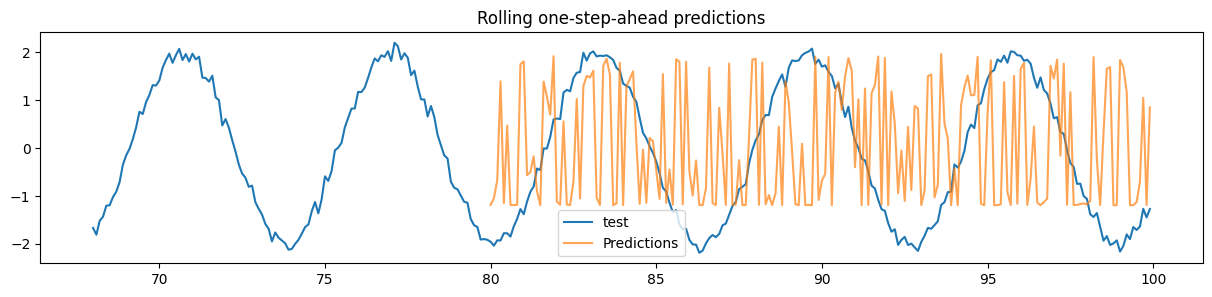

In [72]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(test_time, test_series, label='test')
ax.plot(test_time[WINDOW_SIZE:], ypred, label='Predictions', alpha=0.7)
ax.legend()
ax.set_title('Rolling one-step-ahead predictions')
plt.show()